## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, recall_score, precision_score, accuracy_score, f1_score, RocCurveDisplay, auc

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, model_from_json
from keras.applications import VGG16, ResNet50
# from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import initializers
from keras.losses import BinaryCrossentropy


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
78540,00019271_023.png,Consolidation|Effusion,23,19271,54,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00019271_023.png
106095,00028550_003.png,No Finding,3,28550,47,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00028550_003.png
2792,00000742_003.png,No Finding,3,742,68,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000742_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
data = all_xray_df[all_xray_df['Patient Age']<=100]
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for c_label in all_labels:
    data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
data['pneumonia_class'] = data['Pneumonia'].map(lambda finding: 'pneumonia' if finding==1 else 'non-pneumonia')
data.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non-pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non-pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non-pneumonia


## Create your training and testing data:

In [5]:
def create_splits(df, ratio=0.2):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, valid_df = train_test_split(df, 
                                   test_size = ratio, 
                                   stratify = df['Pneumonia'])
    train_pn = train_df[train_df['Pneumonia']==1]
    train_npn = train_df[train_df['Pneumonia']==0].sample(len(train_pn))
    train_data = shuffle(pd.concat([train_pn, train_npn]))
    
    val_pn = valid_df[valid_df['Pneumonia']==1]
    val_npn = valid_df[valid_df['Pneumonia']==0].sample(4*len(val_pn))
    val_data = shuffle(pd.concat([val_pn, val_npn]))
    
    return train_data, val_data

train_data, val_data = create_splits(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, 'Age')

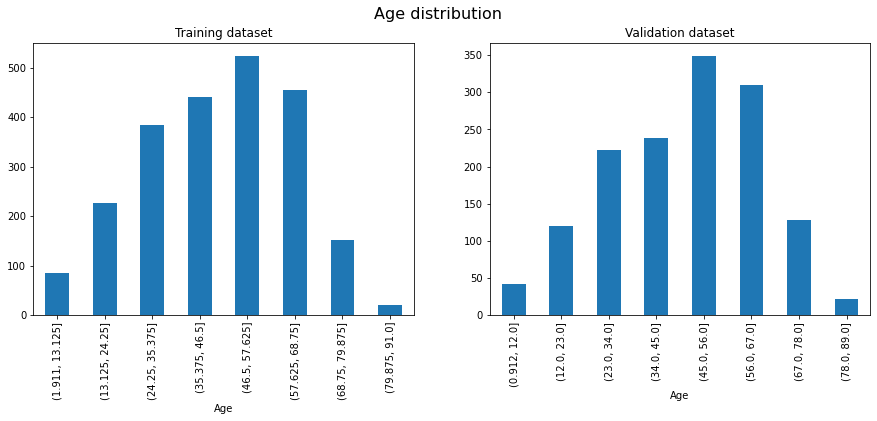

In [6]:
plt.figure(figsize=(15,5))
# plt.title("Age distribution")
plt.suptitle("Age distribution", fontsize=16)
plt.subplot(1,2,1)
# train_data['Patient Age'].value_counts().plot(kind='bar')
train_demog = train_data[['Patient Age', 'Patient Gender']]
train_demog['Age group'] = pd.cut(train_data['Patient Age'], bins=8)
train_demog['Age group'].sort_values().value_counts(sort=False).plot(kind='bar')
plt.title("Training dataset")
plt.xlabel("Age")

plt.subplot(1,2,2)
val_demog = val_data[['Patient Age', 'Patient Gender']]
val_demog['Age group'] = pd.cut(val_data['Patient Age'], bins=8)
val_demog['Age group'].sort_values().value_counts(sort=False).plot(kind='bar')
plt.title("Validation dataset")
plt.xlabel("Age")


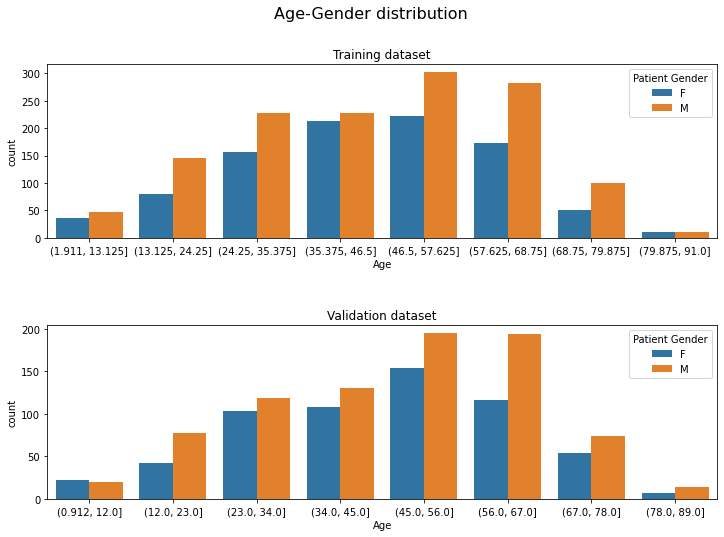

In [7]:
plt.figure(figsize=(12,8))
# plt.title("Age distribution")
plt.suptitle("Age-Gender distribution", fontsize=16)
plt.subplot(2,1,1)
sns.countplot(x='Age group', hue="Patient Gender", data=train_demog)
plt.title("Training dataset")
plt.xlabel("Age")

plt.subplot(2,1,2)
sns.countplot(x='Age group', hue="Patient Gender", data=val_demog)
plt.title("Validation dataset")
plt.xlabel("Age")

plt.subplots_adjust(hspace=.5)


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

---
The following function is served as the image preprocessing stage which first crop the center to focus on the lung region. 
This allows for better image processing by eliminating tons of redundant information that would be extracted from unnecessary and irrelevant body parts such as arms and abdomen. The image is later normalized and standardized using mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] which are the recommended values for VGG model.


In [8]:
# Image Preprocessing function
import tensorflow as tf
def image_prepross(image, rescale=1/255, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image_copy = tf.image.resize(image, (224, 224))
    image_copy = image_copy[25:150, 25:200,:]
    image_copy = rescale*tf.image.resize(image_copy, (224, 224))
    
    image_copy = (image_copy - mean)/std
    
    return image_copy
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


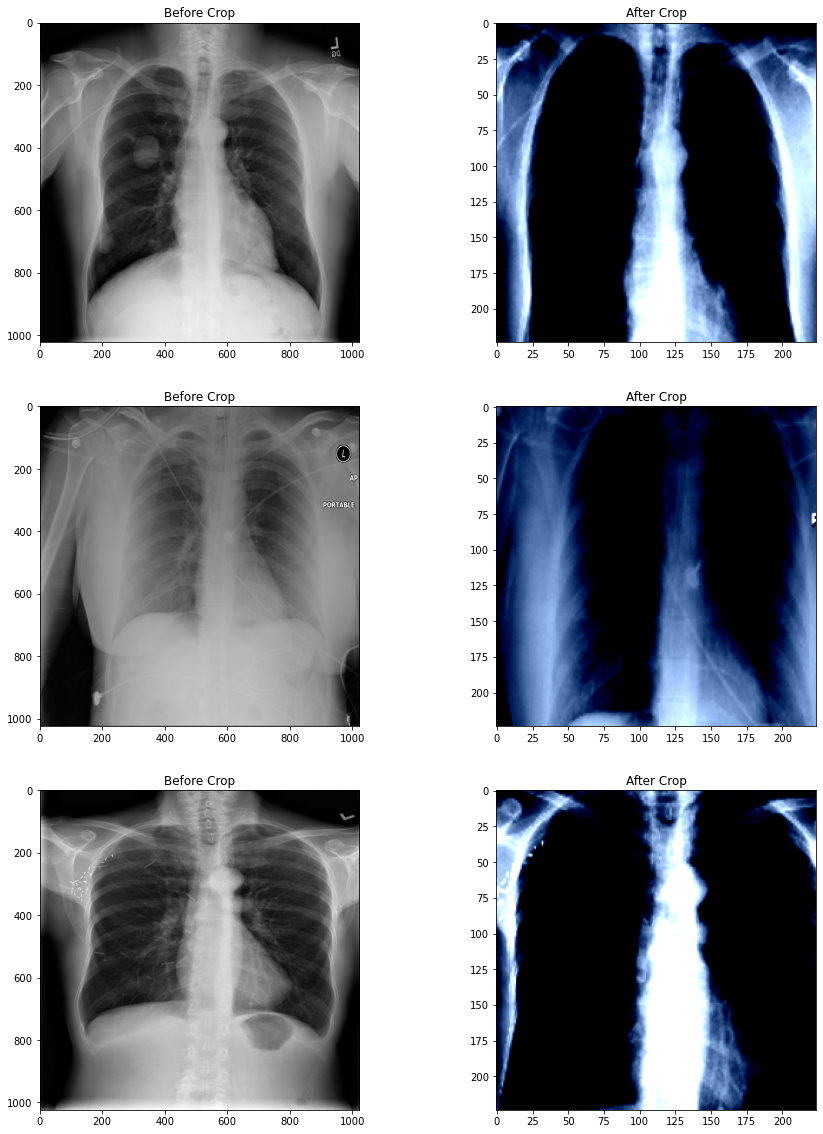

In [9]:
# testing preprcessin fucntion
import PIL
plt.figure(figsize=(15,20))
for i, im in enumerate(train_data.path.sample(3).values.astype(str)):
    img_gray = PIL.Image.open(im)
    img = PIL.Image.new("RGB", img_gray.size)
    img.paste(img_gray)
#     img = image.imread(im, )
    plt.subplot(3,2, 2*i+1)
    plt.imshow(img, cmap='bone')
    plt.title('Before Crop')
    
    plt.subplot(3,2, 2*i+2)
    img = np.asarray(img, dtype=float)
#     img = tf.convert_to_tensor(img)
    croped = image_prepross(img)    
    plt.imshow(croped, cmap='bone')
    plt.title('After Crop')


In [10]:
# rescale is not used as it has already been implemented in preproceeing fucntion
def my_image_augmentation(rescale=0, h_f=True, hsr=1, wsr=1, rr=10):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=rescale,
                                preprocessing_function = image_prepross,
                                horizontal_flip = h_f,
                                vertical_flip = False,
                                height_shift_range= hsr, 
                                width_shift_range=wsr, 
                                rotation_range=rr)
    
    return my_idg


def make_train_gen(df=train_data, target_size= (224, 224), batch_size=32):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
#     my_train_idg = my_image_augmentation(rescale=1/255, h_f=False, hsr=0, wsr=0, rr=0, zr=0)
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=df,
#                                                  directory=None, 
#                                                  x_col = 'path',
#                                                  y_col = 'pneumonia_class',
#                                                  class_mode = 'binary',
#                                                  target_size = target_size,
#                                                  batch_size = len(df), shuffle=True)

    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df,
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = target_size,
                                                 batch_size = batch_size, shuffle=True)
    

    return train_gen


def make_val_gen(df=val_data, target_size= (224, 224),mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    
    my_val_idg = my_image_augmentation(rescale=0, h_f=False, hsr=0, wsr=0, rr=0)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = df,
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = target_size,
                                             batch_size = len(df)) 
    
#     # Todo
    valX, valY = val_gen.next()
    
    return valX, valY#val_gen

Found 2288 validated image filenames belonging to 2 classes.
--- 1.70 seconds ---


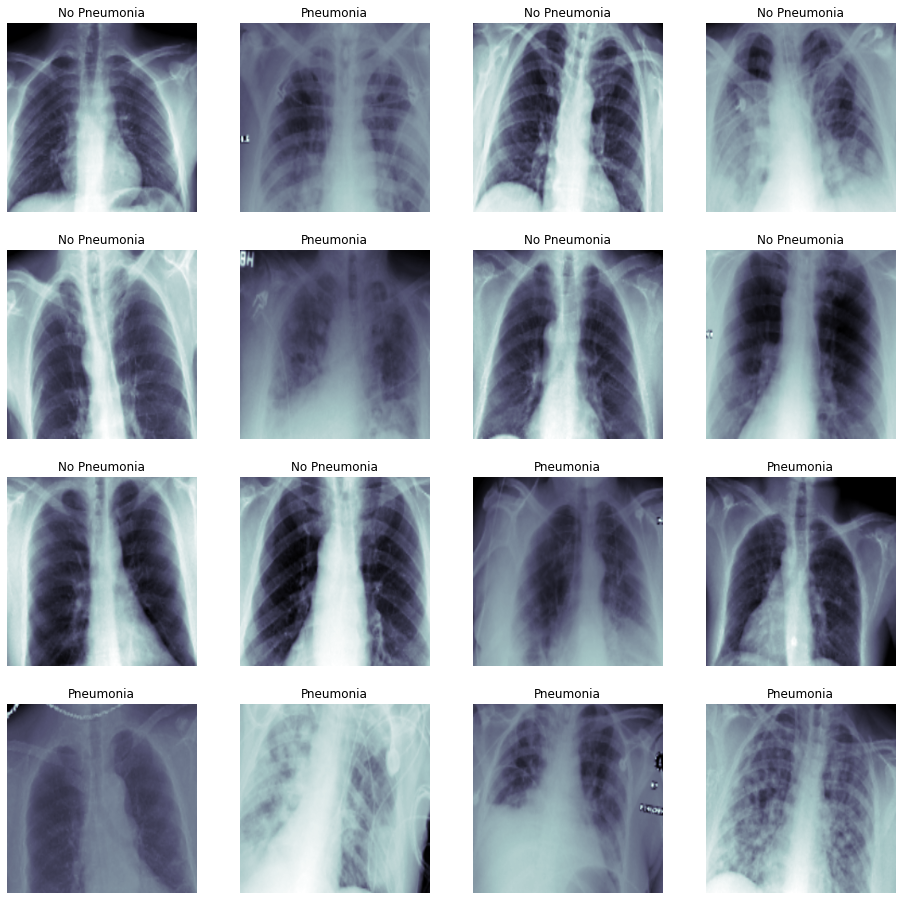

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
import time
start_time = time.time()

train_gen = make_train_gen()
t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

print("--- %.2f seconds ---" % (time.time() - start_time))

In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:

valX, valY = make_val_gen(df=val_data, target_size= (224, 224))

Found 1430 validated image filenames belonging to 2 classes.


## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [41]:
def load_pretrained_model(model_name):
    
    if model_name == 'vgg16':
        model = VGG16(include_top=True, weights='imagenet')
        transfer_layer = model.get_layer('flatten')
        vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

        # Todo
        for layer in vgg_model.layers[0:17]:
            layer.trainable = False

        return vgg_model
    
    elif model_name == 'ResNet50':
        model = ResNet50(include_top=True, weights='imagenet')
        transfer_layer = model.layers[-2]
        resnet_model = Model(inputs = model.input, outputs = transfer_layer.output)

        # Todo
        for layer in resnet_model.layers:
            layer.trainable = False

        return resnet_model
        
vgg_model = load_pretrained_model(model_name='vgg16')
# resnet_model = load_pretrained_model(model_name='ResNet50')

In [42]:
vgg_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [43]:
# from keras.backend import tf as ktf
# import tensorflow as tf
# from keras.layers.experimental.preprocessing import Resizing
# ktf.image.resize_images
# from tensorflow.keras.layers import Cropping2D as c2d
# 3 channel images of arbitrary shape 

def build_my_model(model, lr=.001):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo

    my_model.add(model)
    
    my_model.add(Dense(1024, activation='relu', kernel_initializer=initializers.normal(stddev=.1)))
    my_model.add(Dropout(.3))
    my_model.add(Dense(256, activation='relu', kernel_initializer=initializers.normal(stddev=.1)))
    my_model.add(Dropout(.3))
    my_model.add(Dense(64, activation='relu', kernel_initializer=initializers.normal(stddev=.1)))
    my_model.add(Dropout(.2))
    
    my_model.add(Dense(1, activation='sigmoid', kernel_initializer=initializers.normal(stddev=.1)))
    
    
    optimizer = Adam(lr=lr, beta_1=0.3, beta_2=0.999)#SGD(lr=lr, momentum=.9)
    
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=metrics)
    
    return my_model


my_model = build_my_model(vgg_model)
# my_model = build_my_model(resnet_model)
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [48]:
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 25088)             14714688  
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)               

In [44]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model_vgg4_standardized.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss',#val_binary_accuracy
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min',#, 'max'
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', #'val_binary_accuracy'
                      mode= 'min', #'max'
                      patience=12)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode='min',
                              patience=5, min_lr=1e-6, verbose=1)



callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [45]:
## train your model

# Todo
history = my_model.fit_generator(train_gen,
                                 validation_data =(valX, valY),# val_gen,
                                 epochs = 100,
                                 callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 93s 1s/step - loss: 2.2131 - binary_accuracy: 0.5140 - val_loss: 0.7446 - val_binary_accuracy: 0.4147

Epoch 00001: val_loss improved from inf to 0.74457, saving model to xray_class_my_model_vgg4_standardized.best.hdf5
Epoch 2/100
72/72 [==============================] - 90s 1s/step - loss: 0.7918 - binary_accuracy: 0.5288 - val_loss: 0.7207 - val_binary_accuracy: 0.3371

Epoch 00002: val_loss improved from 0.74457 to 0.72068, saving model to xray_class_my_model_vgg4_standardized.best.hdf5
Epoch 3/100
72/72 [==============================] - 90s 1s/step - loss: 0.7124 - binary_accuracy: 0.5302 - val_loss: 0.6648 - val_binary_accuracy: 0.6944

Epoch 00003: val_loss improved from 0.72068 to 0.66477, saving model to xray_class_my_model_vgg4_standardized.best.hdf5
Epoch 4/100
72/72 [==============================] - 90s 1s/step - loss: 0.6984 - binary_accuracy: 0.5717 - val_loss: 0.6760 - val_binary_accuracy: 0.6021

Epoch 00004: val_los

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [46]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1430/1430 [==============================] - 12s 9ms/step


In [29]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator').plot()
    
    return fpr, tpr, thresholds

## what other performance statistics do you want to include here besides AUC? 


def recal_prec_acc(t_y, p_y):
    rec = recall_score(t_y, p_y)
    per = precision_score(t_y, p_y)
    acc = accuracy_score(t_y, p_y)
    
    print(f'Recall: {rec:.2f}\nPrecision: {per:.2f}\nAccuracy: {acc:.2f}')

    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")
    return

**Attempt 5:**

VGG model with image cropping and standardization. Adam optimizer setting: beta_1= 0.3

2 more last layers unfrozen

Recall: 0.00
Precision: 0.00
Accuracy: 0.80


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


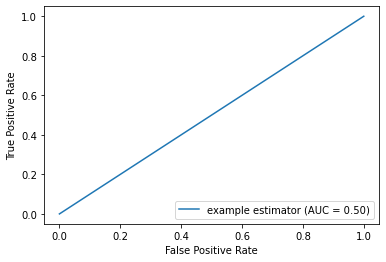

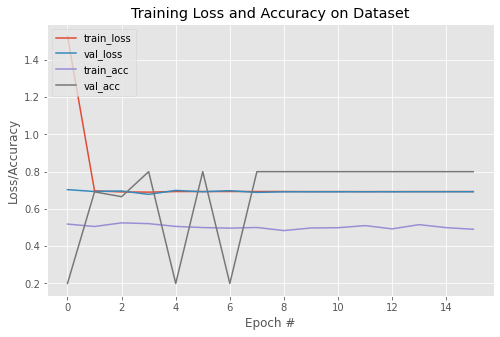

In [30]:
recal_prec_acc(valY, np.round(pred_Y.squeeze()))
fpr, tpr, thresholds=plot_auc(valY, pred_Y)
plot_history(history)

**Attempt 4:**

VGG model with image cropping and standardization. Adam optimizer setting: beta_1= 0.7

Recall: 0.36
Precision: 0.32
Accuracy: 0.72


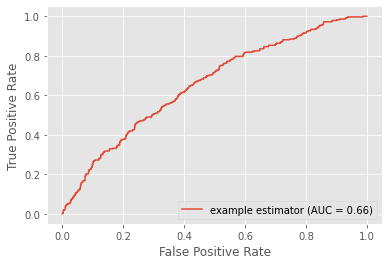

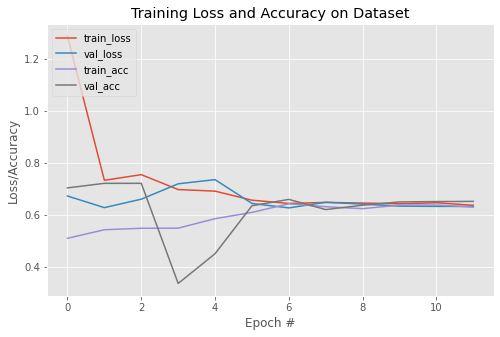

In [46]:

recal_prec_acc(valY, np.round(pred_Y.squeeze()))
fpr, tpr, thresholds=plot_auc(valY, pred_Y)
plot_history(history)

**Attempt 3:**

VGG model with image cropping and standardization. Adam optimizer setting: beta_1= 0.3

Recall: 0.29
Precision: 0.44
Accuracy: 0.78


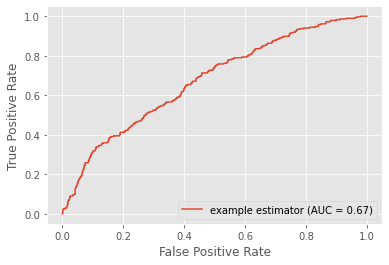

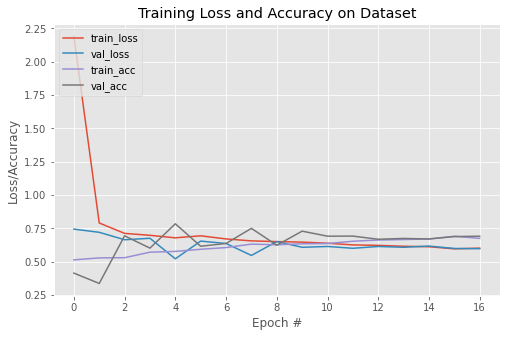

In [47]:
## plot figures
valY #= val_gen.y
recal_prec_acc(valY, np.round(pred_Y.squeeze()))
fpr, tpr, thresholds=plot_auc(valY, pred_Y)
plot_history(history)
# Todo

**Attempt 2:**

VGG model *without image cropping and standardization*. Adam optimizer setting: beta_1= 0.7

Recall: 0.34
Precision: 0.32
Accuracy: 0.72


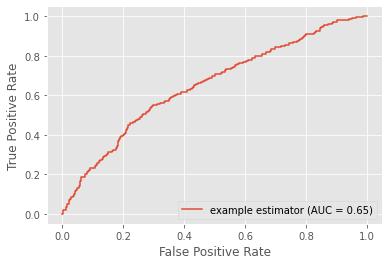

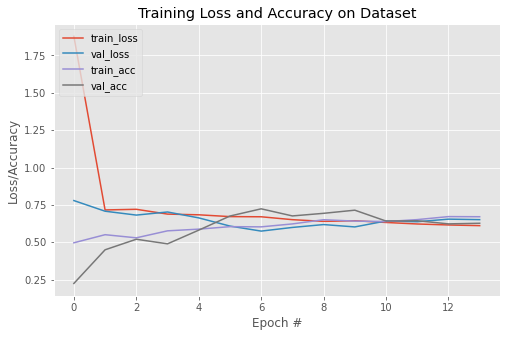

In [44]:
## plot figures
valY #= val_gen.y
recal_prec_acc(valY, np.round(pred_Y.squeeze()))
fpr, tpr, thresholds=plot_auc(valY, pred_Y)
plot_history(history)
# Todo

**Attempt 1:**

VGG model *without image cropping and standardization*.

Recall: 0.17
Precision: 0.23
Accuracy: 0.72


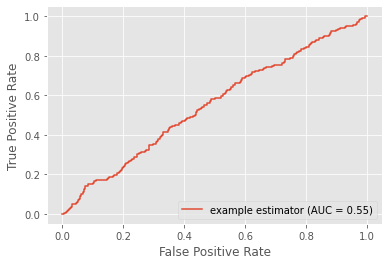

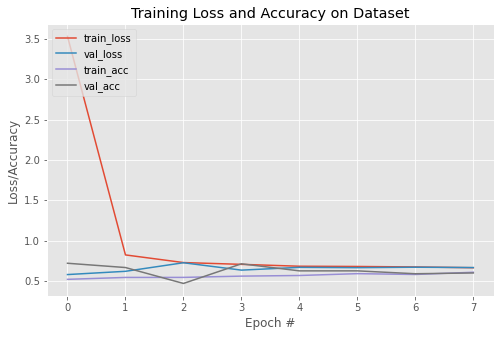

In [62]:
## plot figures
valY #= val_gen.y
recal_prec_acc(valY, np.round(pred_Y.squeeze()))
fpr, tpr, thresholds=plot_auc(valY, pred_Y)
plot_history(history)
# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

___
**Third attempt is selected as the best model**

In [38]:
weight_path="{}_my_model_vgg3_standardized.best.hdf5".format('xray_class')
with open("my_model_vgg_standardized.json", 'r') as json_file:
        json_model= json_file.read()
        
model = model_from_json(json_model)
model.load_weights(weight_path)
    
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1430/1430 [==============================] - 12s 9ms/step


In [48]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
f1=[]
th = np.arange(0,1,.05)
for a in thresholds:
    pred = np.array(pred_Y.squeeze()>a, dtype=int)
    f1.append(f1_score(valY, pred))

# np.argwhere()
idx = np.argmax(f1)
pred = np.array(pred_Y.squeeze()>thresholds[idx], dtype=int)

print(f'The optimum threshold is: {thresholds[idx]:.2f}')
print('Metrics corresponding to the optimum threshold:')
print(f'F1: {f1_score(valY, pred):.2f}')
recal_prec_acc(valY, pred)

The optimum threshold is: 0.32
Metrics corresponding to the optimum threshold:
F1: 0.40
Recall: 0.71
Precision: 0.28
Accuracy: 0.58


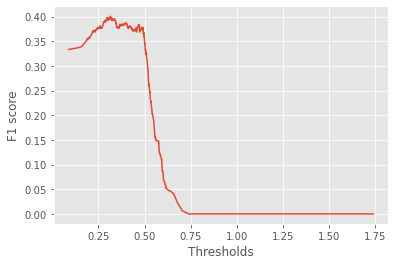

In [50]:
plt.plot(thresholds, f1)
plt.xlabel("Thresholds")
plt.ylabel("F1 score")
plt.show()

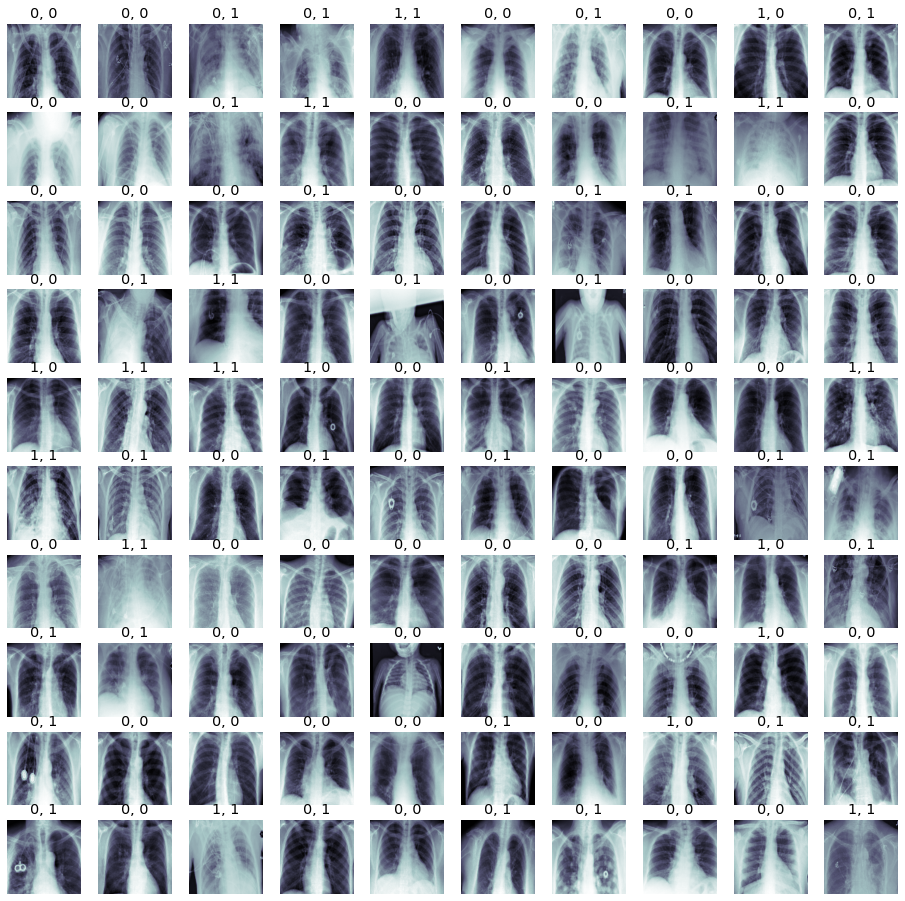

In [67]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresholds[idx]:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresholds[idx]: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [68]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model_vgg_standardized.json", "w") as json_file:
    json_file.write(model_json)